In [181]:
import os
import pandas as pd
import seaborn as sns
import plotly.subplots as subplots
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle



# joblib import
import joblib


import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV

# 최대 재귀함수 깊이 설정
import sys
sys.setrecursionlimit(10**7)

# timedelta import
from datetime import timedelta

# datetime import
from datetime import datetime

# go
import plotly.graph_objects as go

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm



In [182]:
df_origin= pd.read_csv('data/price/price_baechoo.csv')

# 평균 컬럼 가격 컬럼으로 변경
df_origin.rename(columns={'평균':'가격'}, inplace=True)
# 구분 컬럼 날짜 컬럼으로 변경
df_origin.rename(columns={'구분':'날짜'}, inplace=True)

# df_origin 날짜 인덱스로 설정
df_origin.set_index('날짜', inplace=True)
df_origin

,가격
날짜,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [183]:
df_origin.tail(10)

,가격
날짜,
2022-12-07,5488.0
2022-12-08,5408.0
2022-12-09,5408.0
2022-12-12,5244.5
2022-12-13,5245.5
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0
2022-12-19,5459.5


In [205]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df = df_origin.loc['2000':'2022-11-28']
df_test = df_origin.loc['2022-11':'2023-01']

In [185]:
df

,가격
날짜,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-11-22,6260.0
2022-11-23,6100.0
2022-11-24,6100.0


In [206]:
df_test

,가격
날짜,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


비 연속적으로 N개 층이 밀리는 방식

In [187]:
def create_candles(df, group_sizes):
    candles = {}
    for group_size in group_sizes:
        candle_df = pd.DataFrame(columns=['시가', '고가', '저가', '종가', '일자'])
        for i in range(0, len(df), group_size):
            temp = df.iloc[i:i+group_size]
            open_price = temp.iloc[0]['가격']
            high_price = temp['가격'].max()
            low_price = temp['가격'].min()
            close_price = temp.iloc[-1]['가격']
            date = temp.iloc[-1].name
            candle_df = candle_df.append({'시가': open_price, '고가': high_price, '저가': low_price, '종가': close_price, '일자': date}, ignore_index=True)
        candles[group_size] = candle_df
    return candles

candles = create_candles(df, [5, 10, 20, 60, 120])
candle_df_5, candle_df_10, candle_df_20, candle_df_60, candle_df_120 = (candles[size] for size in [5, 10, 20, 60, 120])

# Set the index of each dataframe to the '일자' column and add a new '종가_shift' column
for df in candles.values():
    df.set_index('일자', inplace=True)
    df['종가_shift'] = df['종가'].shift(-1)

# Save the last row of each dataframe to a new dataframe
candle_df_lasts = {key: df.iloc[-1] for key, df in candles.items()}

# Transpose and remove missing values from each dataframe
for df in candle_df_lasts.values():
    df = df.T.dropna()

for df in candles.values():
    df.dropna(inplace=True)


In [188]:
candle_df_5

,시가,고가,저가,종가,종가_shift
일자,,,,,
2000-01-07,5600.0,5700.0,5600.0,5670.0,5630.0
2000-01-13,5770.0,5790.0,5630.0,5630.0,5650.0
2000-01-19,5630.0,5650.0,5630.0,5650.0,5910.0
2000-01-25,5850.0,5910.0,5850.0,5910.0,6620.0
2000-01-31,5930.0,6620.0,5930.0,6620.0,6970.0
...,...,...,...,...,...
2022-10-24,9706.0,9706.0,8583.0,8663.0,7792.5
2022-10-31,8172.0,8252.0,7792.5,7792.5,7330.0
2022-11-07,7350.0,7381.5,6835.5,7330.0,6724.0


In [208]:
candle_df_10

,시가,고가,저가,종가,종가_shift
일자,,,,,
2000-01-13,5600.0,5790.0,5600.0,5630.0,5910.0
2000-01-25,5630.0,5910.0,5630.0,5910.0,6970.0
2000-02-08,5930.0,6970.0,5930.0,6970.0,8370.0
2000-02-19,7230.0,8690.0,7230.0,8370.0,7630.0
2000-03-03,8030.0,8030.0,7430.0,7630.0,7990.0
...,...,...,...,...,...
2022-09-15,24800.0,37800.0,24800.0,33140.0,23520.0
2022-09-29,31920.0,36920.0,23520.0,23520.0,10623.0
2022-10-17,22620.0,23500.0,10623.0,10623.0,7792.5


In [190]:
candle_df_lasts[60]

시가          24800.0
고가          37800.0
저가           5664.0
종가           5664.0
종가_shift        NaN
Name: 2022-11-28, dtype: float64

In [191]:
# 캔들 스틱 차트 그리기 제목추가=candle_df 변수명
def candle_stick_chart(candle_df):
    fig = go.Figure(data=[go.Candlestick(x=candle_df.index,
                                         open=candle_df['시가'],
                                         high=candle_df['고가'],
                                         low=candle_df['저가'],
                                         close=candle_df['종가'])])
    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

    

# 캔들 스틱 차트 그리기
candle_stick_chart(candle_df_5)
candle_stick_chart(candle_df_10)
candle_stick_chart(candle_df_20)
candle_stick_chart(candle_df_60)
candle_stick_chart(candle_df_120)


In [192]:
def scale_data(days):
    # select the data for the given number of days
    feature = eval(f'candle_df_{days}')[['시가', '고가', '저가','종가']]
    target = eval(f'candle_df_{days}')[['종가_shift']]
    
    # scale the data
    scaler1 = MinMaxScaler()
    scaler2 = MinMaxScaler()
    feature_scaled = scaler1.fit_transform(feature)
    target_scaled = scaler2.fit_transform(target)
    
    # convert the scaled data to a Pandas DataFrame
    feature_scaled = pd.DataFrame(feature_scaled, columns=feature.columns, index=feature.index)
    target_scaled = pd.DataFrame(target_scaled, columns=target.columns, index=target.index)

    # Save the scaler for the feature data
    with open(f'model/price_candle_scaler1_{days}.pkl', 'wb') as f:
        pickle.dump(scaler1, f)
    with open(f'model/price_candle_scaler2_{days}.pkl', 'wb') as f:
        pickle.dump(scaler2, f)
    
    return feature_scaled, target_scaled


feature_5, target_5 = scale_data(5)
feature_10, target_10 = scale_data(10)
feature_20, target_20 = scale_data(20)
feature_60, target_60 = scale_data(60)
feature_120, target_120 = scale_data(120)

In [193]:
def split_data(feature, target, test_size=0.2, shuffle=False, random_state=42):
  train_X, test_X, train_y, test_y = train_test_split(feature, target, test_size=test_size, shuffle=shuffle, random_state=random_state)
  return train_X, test_X, train_y, test_y

In [194]:
# 시각화 함수
def plot_predictions(test_y, y_pred, title):
    plt.figure(figsize=(20, 10))
    plt.plot(test_y, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Best hyperparameters for time period 5: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.5}
Best score for time period 5: 0.8966602505936994
RMSE for time period 5: 0.07078456636595712
r2 score for time period 5: 0.8057506611795663


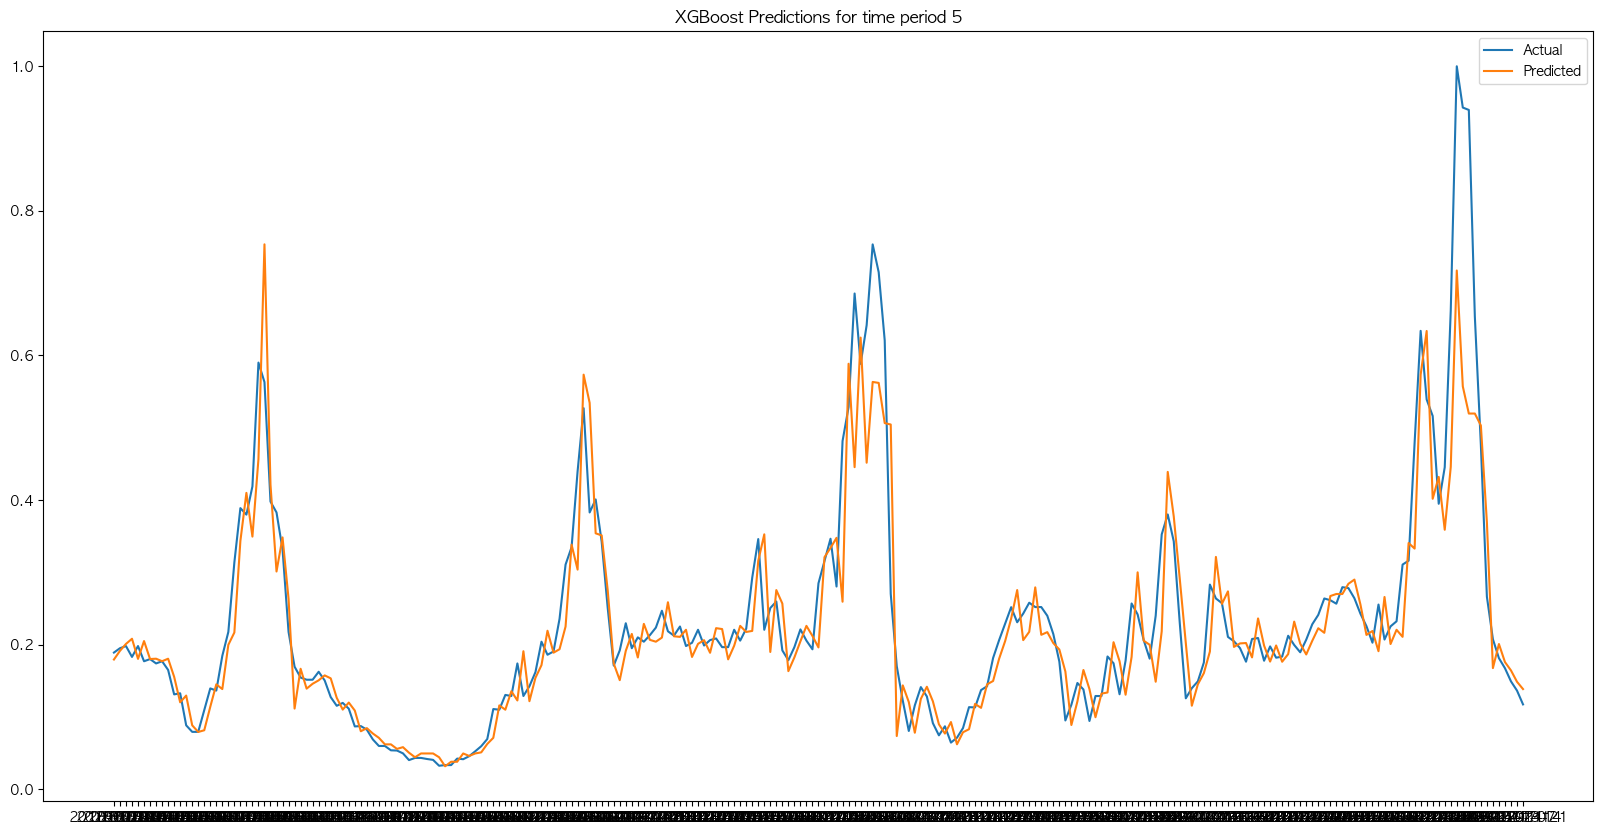

 20%|██        | 1/5 [09:02<36:11, 542.93s/it]

Best hyperparameters for time period 10: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}
Best score for time period 10: 0.7714735410432393
RMSE for time period 10: 0.11381521109940408
r2 score for time period 10: 0.5251381344427752


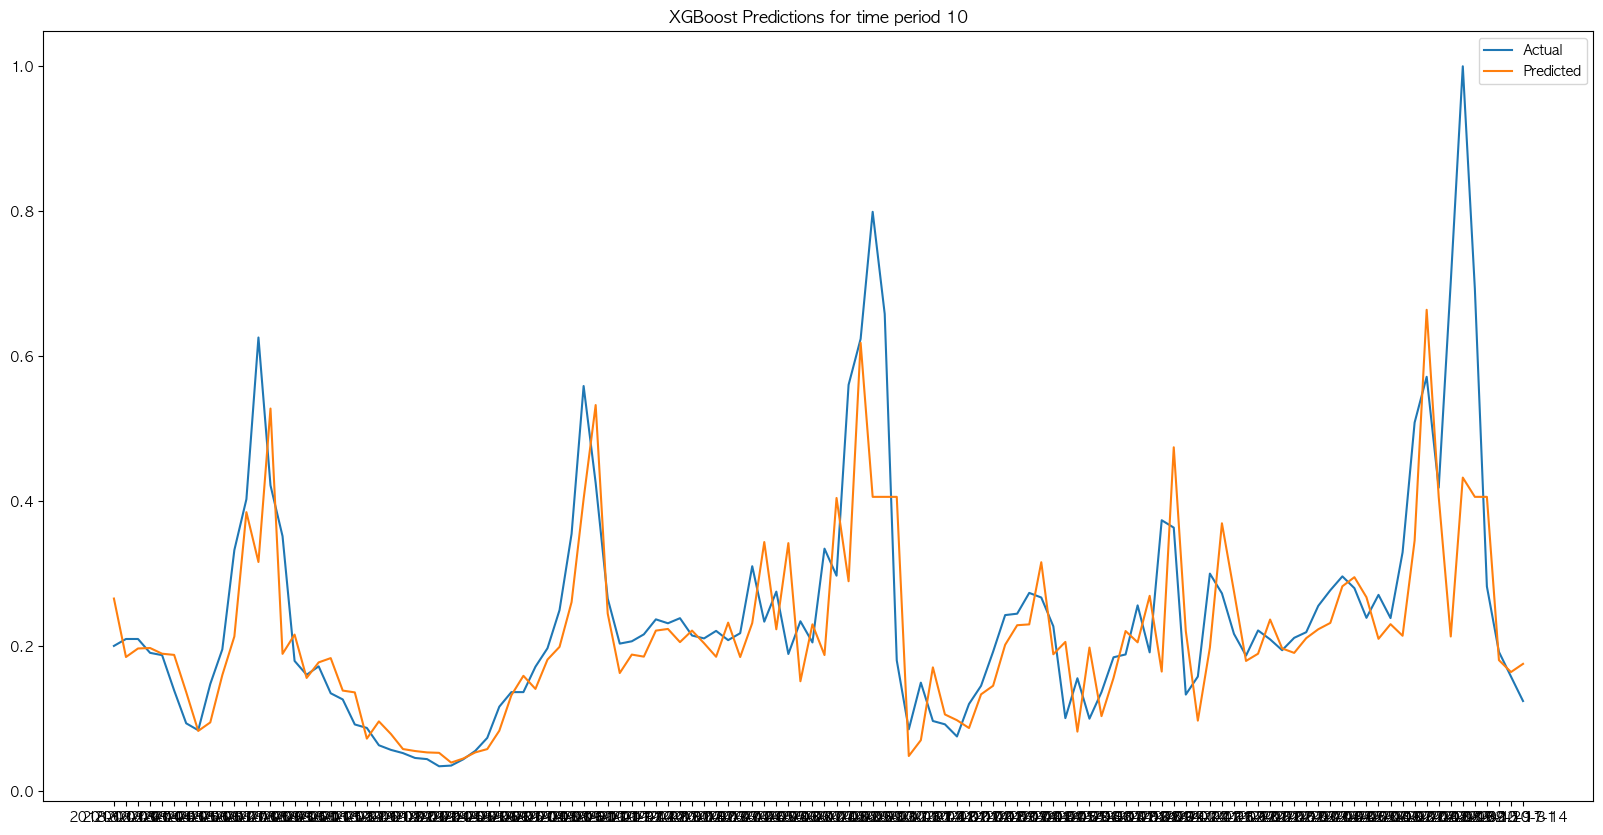

 40%|████      | 2/5 [14:55<21:33, 431.09s/it]

Best hyperparameters for time period 20: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 1}
Best score for time period 20: 0.3078528740200751
RMSE for time period 20: 0.17357028427155774
r2 score for time period 20: 0.18415116400730724


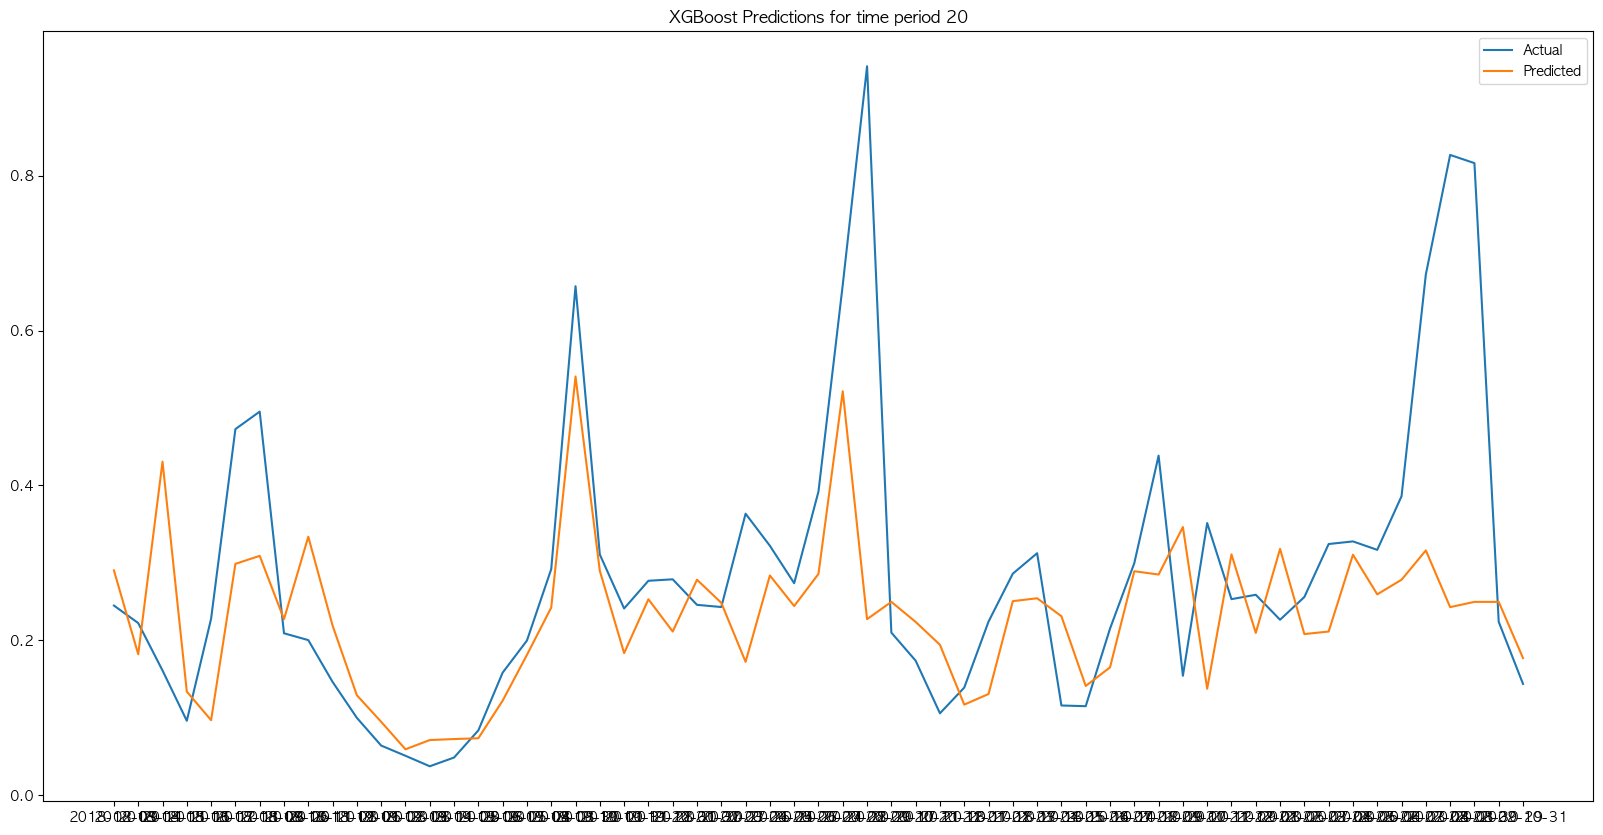

 60%|██████    | 3/5 [19:27<11:56, 358.45s/it]

Best hyperparameters for time period 60: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'subsample': 0.7}
Best score for time period 60: -0.09609820667052953
RMSE for time period 60: 0.29310554200436645
r2 score for time period 60: -0.39402685260109727


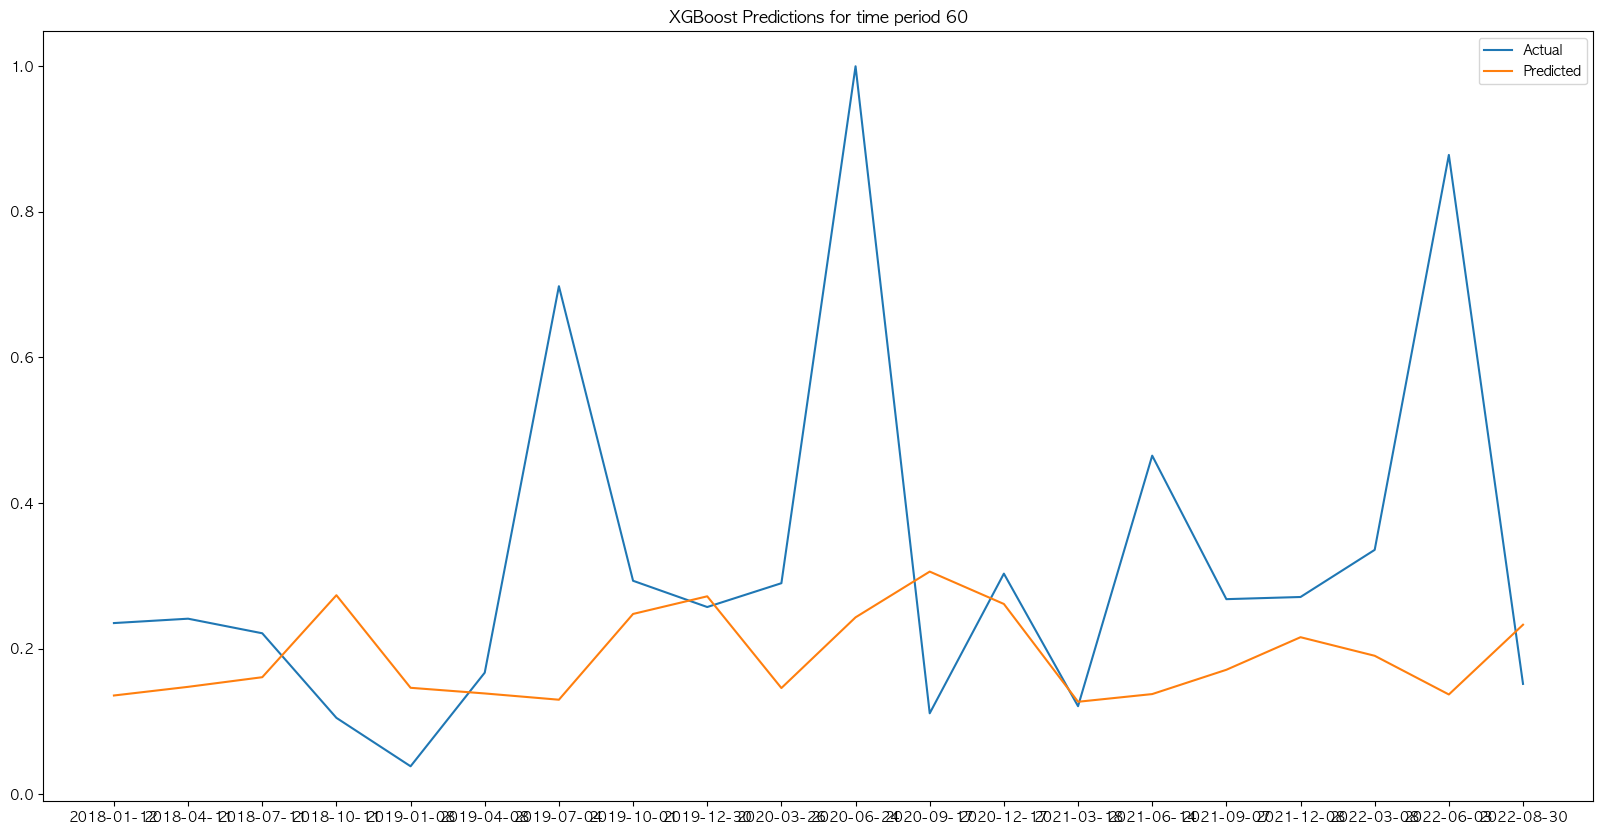

 80%|████████  | 4/5 [22:23<04:46, 286.25s/it]

Best hyperparameters for time period 120: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}
Best score for time period 120: -0.3456604898479346
RMSE for time period 120: 0.21519190877341982
r2 score for time period 120: -0.0396201473999529


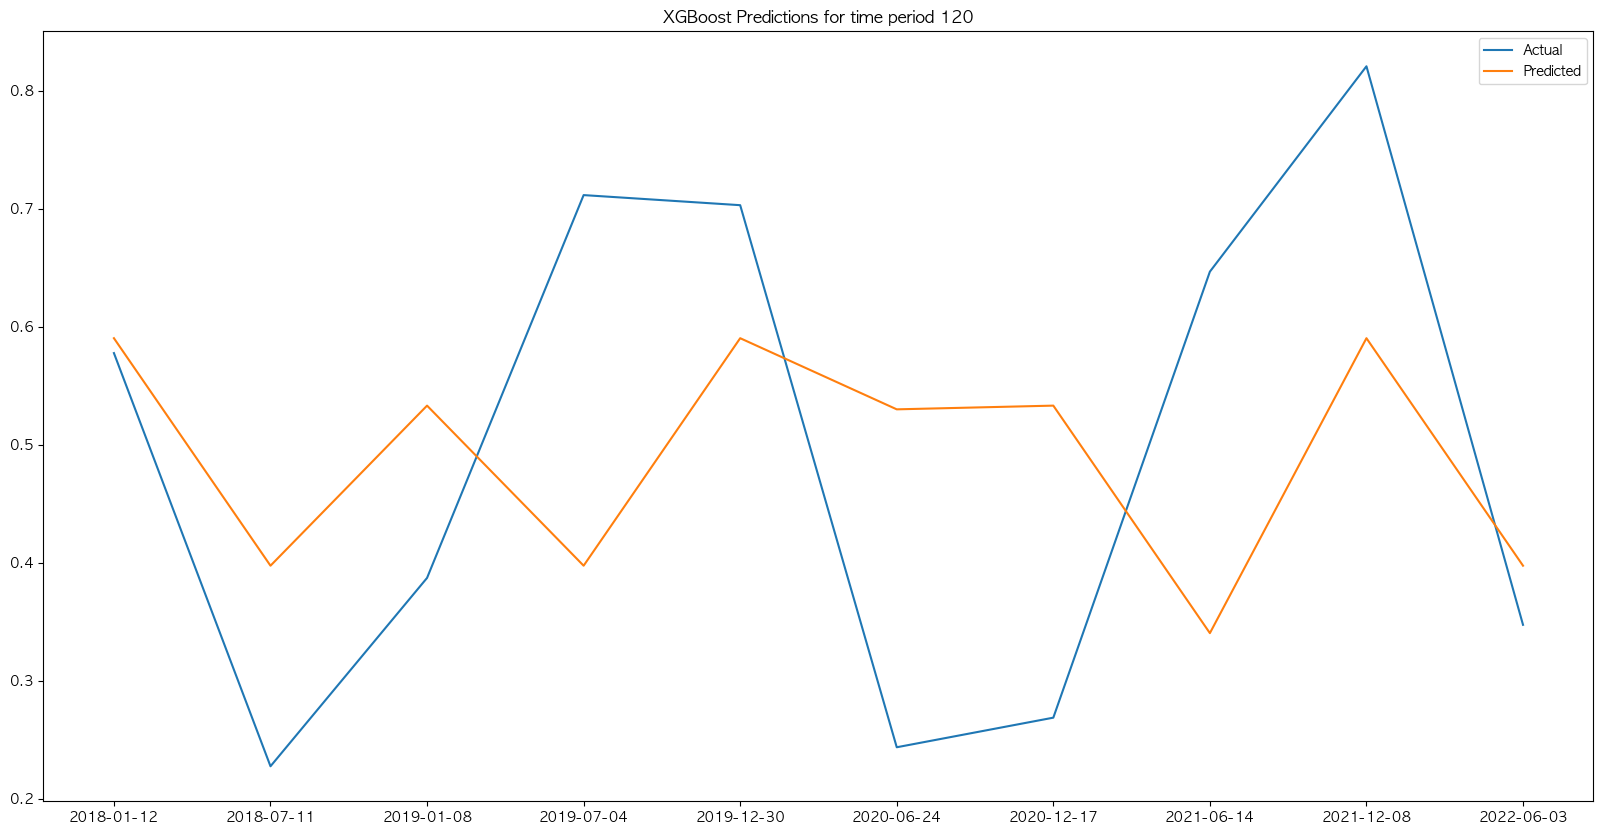

100%|██████████| 5/5 [24:43<00:00, 296.66s/it]


In [195]:
for n in tqdm([5, 10, 20, 60, 120]):
    # Split the data into training and testing sets
    train_X, test_X, train_y, test_y = split_data(eval(f"feature_{n}"), eval(f"target_{n}"))

    # Create an XGBoost model
    xgb = XGBRegressor()

    # Set the hyperparameters for the model
    params = {'n_estimators': [10,50 ,100, 200, 300,400,500], 'learning_rate': [0.005 ,0.01, 0.05, 0.1],
                'max_depth': [1, 3, 5, 7], 'colsample_bytree': [0.5, 0.7, 1],
                'subsample': [0.5, 0.7, 1], 'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [0.005, 0.01,0.5,0.1,0]}

    # Use a grid search to find the best hyperparameters for the model
    grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
    grid_cv.fit(train_X, train_y)

    # Print the best hyperparameters found by the grid search
    print('Best hyperparameters for time period {}:'.format(n), grid_cv.best_params_)
    print('Best score for time period {}:'.format(n), grid_cv.best_score_)

    # Create a new XGBoost model using the best hyperparameters
    xgb = XGBRegressor(**grid_cv.best_params_)

    # Train the model
    xgb.fit(train_X, train_y)

    # Evaluate the model
    y_pred = xgb.predict(test_X)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    print('RMSE for time period {}:'.format(n), rmse)
    r2 = r2_score(test_y, y_pred)
    print('r2 score for time period {}:'.format(n), r2)

    # Plot the predictions
    plot_predictions(test_y, y_pred, 'XGBoost Predictions for time period {}'.format(n))

    # Save the model
    pickle.dump(xgb, open('model/price_candle_XGBoost_static_{}days.pkl'.format(n), 'wb'))


In [196]:
candle_df_lasts[5]

시가          6260.0
고가          6260.0
저가          5664.0
종가          5664.0
종가_shift       NaN
Name: 2022-11-28, dtype: float64

In [197]:
def predict_price(days):
  # Load the model and scalers
  model = pickle.load(open('model/price_candle_XGBoost_static_{}days.pkl'.format(days), 'rb'))
  scaler1 = pickle.load(open('model/price_candle_scaler1_{}.pkl'.format(days), 'rb'))
  scaler2 = pickle.load(open('model/price_candle_scaler2_{}.pkl'.format(days), 'rb'))

  # Select the last `days` days of data
  candle_df_last_x = candle_df_lasts[days]

  # Drop the '종가_shift' column
  candle_df_last_x = candle_df_last_x.drop('종가_shift')

  # Convert candle_df_last_x to a Pandas dataframe
  candle_df_last_x = pd.DataFrame(candle_df_last_x)
  candle_df_last_x= candle_df_last_x.T

  # Model predict using test_data
  test_data_sc = scaler1.transform(candle_df_last_x)
  test_data_sc = pd.DataFrame(test_data_sc, columns=candle_df_last_x.columns, index=candle_df_last_x.index)
  y_pred = model.predict(test_data_sc)

  # reshape y_pred
  y_pred = y_pred.reshape(-1,1)

  # Inverse transform y_pred
  y_pred = scaler2.inverse_transform(y_pred)

  # Return the predicted values
  return y_pred

print(predict_price(5))
print(predict_price(10))
print(predict_price(20))
print(predict_price(60))
print(predict_price(120))


[[5454.86]]
[[5976.931]]
[[5274.104]]
[[8691.492]]
[[7467.6313]]


In [207]:
# Create a list of time periods to iterate over
time_periods = [5, 10, 20, 60, 120]

# Create an empty list to store the dataframes
df_list = []

# Iterate over the time periods
for period in time_periods:
  # Create a new dataframe for this time period
  df = pd.DataFrame(columns=['Actual', 'Predicted', 'Error'])

  df['Actual'] = df_test.iloc[19]
  df['Predicted'] = predict_price(period)
  
  # Calculate the error rate
  df['Error'] = (df['Predicted']-df['Actual']) / df['Actual'] * 100
  
  # Add the dataframe to the list
  df_list.append(df)

# Concatenate the dataframes
df = pd.concat(df_list)

df

,Actual,Predicted,Error
가격,5664.0,5454.859863,-3.692446
가격,5664.0,5976.931152,5.524914
가격,5664.0,5274.104004,-6.883757
가격,5664.0,8691.492188,53.451486
가격,5664.0,7467.631348,31.843774
